In [2]:
import json
import os
from io import BytesIO

import matplotlib.patches as patches
import matplotlib.pyplot as plt
import oci
from PIL import Image

In [3]:
config = oci.config.from_file()

In [4]:
# Initialize service client with default config file
ai_document_client = oci.ai_document.AIServiceDocumentClient(config)

In [5]:
#Object storage Namespace
object_storage_client = oci.object_storage.ObjectStorageClient(config)
NAMESPACE = object_storage_client.get_namespace().data

#Name of Bucket for this demo
BUCKET_NAME = 'bucket-pruebas'

PREFIX = "notebook"

FILENAME = "boleta.jpg"

DATASET_PATH = "sample_documents"

In [6]:
response = object_storage_client.put_object(NAMESPACE, BUCKET_NAME, FILENAME, open(os.path.join(DATASET_PATH, FILENAME), "rb"))
response.status

200

In [7]:
response = object_storage_client.get_object(NAMESPACE, BUCKET_NAME, FILENAME)
response.status

200

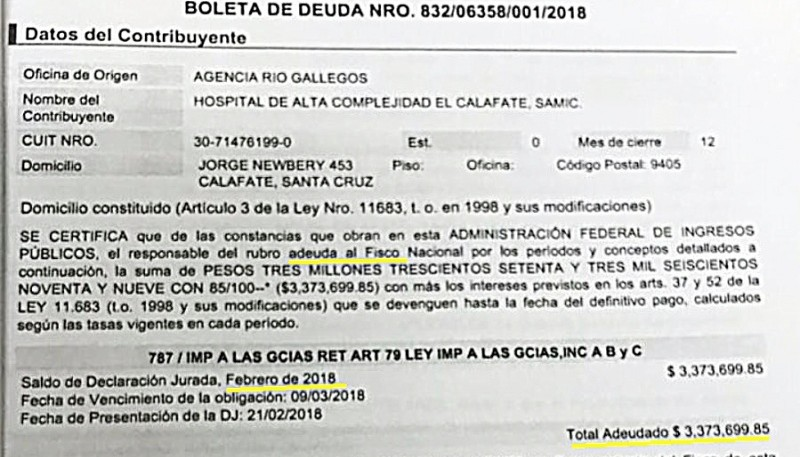

In [8]:
image = Image.open(BytesIO(response.data.content))
image

In [9]:
image.width

800

In [10]:
# Initialize service client with default config file
ai_document_client = oci.ai_document.AIServiceDocumentClient(config)

In [11]:
# Send the request to service, some parameters are not required, see API
# doc for more info
create_processor_job_response = ai_document_client.create_processor_job(
    create_processor_job_details=oci.ai_document.models.CreateProcessorJobDetails(
        input_location=oci.ai_document.models.ObjectStorageLocations(
            source_type="OBJECT_STORAGE_LOCATIONS",
            object_locations=[
                oci.ai_document.models.ObjectLocation(
                    namespace_name=NAMESPACE,
                    bucket_name=BUCKET_NAME,
                    object_name=FILENAME)]),
        output_location=oci.ai_document.models.OutputLocation(
            namespace_name=NAMESPACE,
            bucket_name=BUCKET_NAME,
            prefix=PREFIX),
        compartment_id=config["compartment_id"],
        processor_config=oci.ai_document.models.GeneralProcessorConfig(
            processor_type="GENERAL",
            features=[
                oci.ai_document.models.DocumentTextExtractionFeature(
                    feature_type="TEXT_EXTRACTION",
                    generate_searchable_pdf=True)],
            document_type="OTHERS",
            is_zip_output_enabled=True,
            language="es"),
        display_name="EXAMPLE-displayName-Value"),
    opc_retry_token="EXAMPLE-opcRetryToken-Value",
    opc_request_id="MOZIJVR14UCLBIBEOUH8<unique_ID>")


In [12]:
output_location = "{}_{}".format(create_processor_job_response.data.output_location.namespace_name, create_processor_job_response.data.output_location.bucket_name)

In [13]:
results_path = os.path.join(PREFIX, create_processor_job_response.data.id, output_location, "results", FILENAME+".json")

In [14]:
response = object_storage_client.get_object(NAMESPACE, BUCKET_NAME, results_path)
response.status

200

In [15]:
bytes_json = response.data.content
json_data = json.loads(bytes_json)
json_data

{'documentMetadata': {'pageCount': 1, 'mimeType': 'image/jpeg'},
 'pages': [{'pageNumber': 1,
   'dimensions': {'width': 800.0, 'height': 457.0, 'unit': 'PIXEL'},
   'detectedDocumentTypes': None,
   'detectedLanguages': None,
   'words': [{'text': 'BOLETA',
     'confidence': 0.9892046,
     'boundingPolygon': {'normalizedVertices': [{'x': 0.23125,
        'y': 2.1718945802562345e-05},
       {'x': 0.32, 'y': 0.0015637641140877287},
       {'x': 0.32, 'y': 0.03438652213866653},
       {'x': 0.23125, 'y': 0.032844476678960954}]}},
    {'text': 'DE',
     'confidence': 0.9892046,
     'boundingPolygon': {'normalizedVertices': [{'x': 0.32875,
        'y': 0.0017157967815774797},
       {'x': 0.36375, 'y': 0.002323927190684646},
       {'x': 0.36375, 'y': 0.03514668404143018},
       {'x': 0.32875, 'y': 0.034538552849767507}]}},
    {'text': 'DEUDA',
     'confidence': 0.9892046,
     'boundingPolygon': {'normalizedVertices': [{'x': 0.3675,
        'y': 0.002389084066812528},
       {'x':

In [16]:
words = json_data["pages"][0]["words"]
text_in_words = " ".join([word["text"] for word in words])
text_in_words

'BOLETA DE DEUDA NRO. 832/06358/001/2018 Datos del Contribuyente Oficina de Origen AGENCIA RIO GALLEGOS Nombre del HOSPITAL DE ALTA COMPLEJIDAD EL CALAFATE, SAMIC. Contribuyente CUIT NRO. 30-71476199-0 Est. 0 Mes de cierre 12 Domicilio JORGE NEWBERY 453 Piso: Oficina: Código Postal 9405 CALAFATE, SANTA CRUZ Domicilio constituido (Artículo 3 de la Ley Nro. 11683, t. o. en 1998 y sus modificaciones) SE CERTIFICA que de las constancias que obran en esta ADMINISTRACIÓN FEDERAL DE INGRESOS PUBLICOS, el responsable del rubro adeuda al Fisco Nacional por los periodos y conceptos detallados a continuación, la suma de PESOS TRES MILLONES TRESCIENTOS SETENTA Y TRES MIL SEISCIENTOS NOVENTA Y NUEVE CON 85/100--* ($3,373,699.85) con más los intereses previstos en los arts. 37 y 52 de la LEY 11.683 (L.o. 1998 y sus modificaciones) que se devenguen hasta la fecha del definitive pago, calculados según las tasas vigentes en cada periodo. 787 / IMP A LAS GCIAS RET ART 79 LEY IMP A LAS GCIAS,INC A By C S

In [17]:
ai_language_client = oci.ai_language.AIServiceLanguageClient(config)

In [18]:
language = ai_language_client.detect_dominant_language(oci.ai_language.models.DetectDominantLanguageDetails(text=text_in_words)).data
language

{
  "languages": [
    {
      "code": "es",
      "name": "Spanish",
      "score": 1.0
    }
  ]
}

In [19]:
key_phrases = ai_language_client.detect_language_key_phrases(oci.ai_language.models.DetectLanguageKeyPhrasesDetails(text=text_in_words,)).data
key_phrases

{
  "key_phrases": [
    {
      "score": 0.9999994197569447,
      "text": "modificaciones"
    },
    {
      "score": 0.9999994197569447,
      "text": "gcias"
    },
    {
      "score": 0.9998106383818767,
      "text": "contribuyente oficina"
    },
    {
      "score": 0.9998106383818767,
      "text": "cierre 12 domicilio jorge"
    },
    {
      "score": 0.9998106383818767,
      "text": "453 piso"
    },
    {
      "score": 0.9998106383818767,
      "text": "código postal 9405 calafate"
    },
    {
      "score": 0.9998106383818767,
      "text": "santa cruz domicilio"
    },
    {
      "score": 0.9998106383818767,
      "text": "artículo 3"
    },
    {
      "score": 0.9998106383818767,
      "text": "ley nro . 11683"
    },
    {
      "score": 0.9998106383818767,
      "text": "se certifica"
    },
    {
      "score": 0.9998106383818767,
      "text": "ingresos publicos"
    },
    {
      "score": 0.9998106383818767,
      "text": "fisco nacional"
    },
    {
     

In [20]:
pii = ai_language_client.batch_detect_language_pii_entities(oci.ai_language.models.BatchDetectLanguagePiiEntitiesDetails(
    documents=[
        oci.ai_language.models.TextDocument(
            key="1",
            text=text_in_words
        )
    ]
)).data
pii

{
  "documents": [
    {
      "entities": [
        {
          "id": "1",
          "length": 13,
          "offset": 235,
          "score": 0.8525392413139343,
          "text": "JORGE NEWBERY",
          "type": "PERSON"
        },
        {
          "id": "2",
          "length": 4,
          "offset": 373,
          "score": 0.969440758228302,
          "text": "1998",
          "type": "DATE_TIME"
        },
        {
          "id": "3",
          "length": 7,
          "offset": 996,
          "score": 0.7613521814346313,
          "text": "C Saldo",
          "type": "PERSON"
        },
        {
          "id": "4",
          "length": 15,
          "offset": 1027,
          "score": 0.9825289646784464,
          "text": "Febrero de 2018",
          "type": "DATE_TIME"
        },
        {
          "id": "5",
          "length": 10,
          "offset": 1097,
          "score": 0.9998934864997864,
          "text": "09/03/2018",
          "type": "DATE_TIME"
        },
   

In [21]:
dimensions = json_data["pages"][0]["dimensions"]

width = dimensions["width"]
height = dimensions["height"]

dimensions

{'width': 800.0, 'height': 457.0, 'unit': 'PIXEL'}

In [22]:
def xyxy_to_xywh(x1, y1, x2, y2):
    return x1, y1, x2 - x1, y2 - y1

def xyxy_to_cxcywh(x1, y1, x2, y2):
    return (x1 + x2) / 2, (y1 + y2) / 2, x2 - x1, y2 - y1

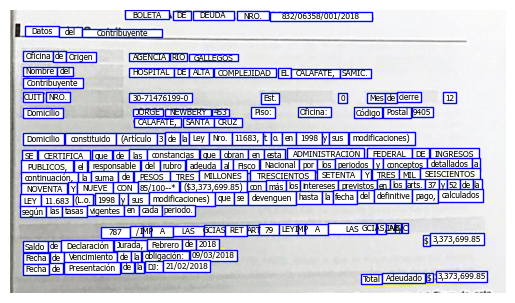

In [23]:
fig, ax = plt.subplots()

ax.imshow(image)

for word in words:
    x, y, w, h = xyxy_to_xywh(word["boundingPolygon"]["normalizedVertices"][1]["x"], word["boundingPolygon"]["normalizedVertices"][1]["y"],
                                word["boundingPolygon"]["normalizedVertices"][3]["x"], word["boundingPolygon"]["normalizedVertices"][3]["y"])
    
    cx, cy, w, h = xyxy_to_cxcywh(word["boundingPolygon"]["normalizedVertices"][1]["x"], word["boundingPolygon"]["normalizedVertices"][1]["y"],
                                word["boundingPolygon"]["normalizedVertices"][3]["x"], word["boundingPolygon"]["normalizedVertices"][3]["y"])
    
    rect = patches.Rectangle((x * width, y * height), w * width, h * height, linewidth=1, edgecolor='blue', facecolor='white')

    ax.text(cx * width, cy * height, word["text"], horizontalalignment='center',
    verticalalignment='center', fontsize=6, color='black', fontfamily="Tahoma")
    # Add the patch to the Axes
    ax.add_patch(rect)

ax.set_axis_off()
plt.savefig('output.png')
plt.show()


In [24]:
pii_words = [pii_words.text for pii_words in pii.documents[0].entities]
pii_words

['JORGE NEWBERY',
 '1998',
 'C Saldo',
 'Febrero de 2018',
 '09/03/2018',
 '21/02/2018']

In [25]:
text_in_words

'BOLETA DE DEUDA NRO. 832/06358/001/2018 Datos del Contribuyente Oficina de Origen AGENCIA RIO GALLEGOS Nombre del HOSPITAL DE ALTA COMPLEJIDAD EL CALAFATE, SAMIC. Contribuyente CUIT NRO. 30-71476199-0 Est. 0 Mes de cierre 12 Domicilio JORGE NEWBERY 453 Piso: Oficina: Código Postal 9405 CALAFATE, SANTA CRUZ Domicilio constituido (Artículo 3 de la Ley Nro. 11683, t. o. en 1998 y sus modificaciones) SE CERTIFICA que de las constancias que obran en esta ADMINISTRACIÓN FEDERAL DE INGRESOS PUBLICOS, el responsable del rubro adeuda al Fisco Nacional por los periodos y conceptos detallados a continuación, la suma de PESOS TRES MILLONES TRESCIENTOS SETENTA Y TRES MIL SEISCIENTOS NOVENTA Y NUEVE CON 85/100--* ($3,373,699.85) con más los intereses previstos en los arts. 37 y 52 de la LEY 11.683 (L.o. 1998 y sus modificaciones) que se devenguen hasta la fecha del definitive pago, calculados según las tasas vigentes en cada periodo. 787 / IMP A LAS GCIAS RET ART 79 LEY IMP A LAS GCIAS,INC A By C S

In [26]:
filtered_pii_words = list(filter(lambda word: word["text"] in pii_words, words))
filtered_pii_words

[{'text': '1998',
  'confidence': 0.97050273,
  'boundingPolygon': {'normalizedVertices': [{'x': 0.576875,
     'y': 0.43173418107648387},
    {'x': 0.6275, 'y': 0.43159418085210954},
    {'x': 0.6275, 'y': 0.47535785700090605},
    {'x': 0.576875, 'y': 0.4754978572252804}]}},
 {'text': '1998',
  'confidence': 0.9638545,
  'boundingPolygon': {'normalizedVertices': [{'x': 0.17,
     'y': 0.648563643774788},
    {'x': 0.218125, 'y': 0.647435828945569},
    {'x': 0.218125, 'y': 0.6933876889018052},
    {'x': 0.17, 'y': 0.6945155037310243}]}},
 {'text': '09/03/2018',
  'confidence': 0.9930426,
  'boundingPolygon': {'normalizedVertices': [{'x': 0.3616643524169922,
     'y': 0.849251511321287},
    {'x': 0.4563166809082031, 'y': 0.8468570500547046},
    {'x': 0.4563197708129883, 'y': 0.8841823853340399},
    {'x': 0.3619158935546875, 'y': 0.887030937478631}]}},
 {'text': '21/02/2018',
  'confidence': 0.99151146,
  'boundingPolygon': {'normalizedVertices': [{'x': 0.307738094329834,
     'y': 

In [32]:
width, height = image.width, image.height

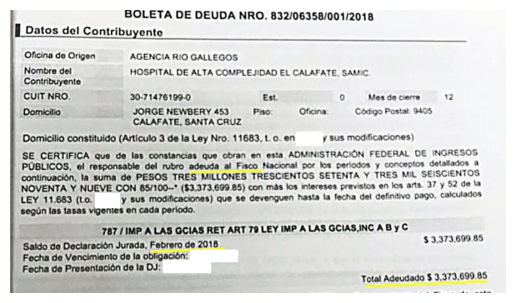

In [37]:
fig, ax = plt.subplots()

ax.imshow(image)

for word in filtered_pii_words:
    x, y, w, h = xyxy_to_xywh(word["boundingPolygon"]["normalizedVertices"][1]["x"], word["boundingPolygon"]["normalizedVertices"][1]["y"],
                                word["boundingPolygon"]["normalizedVertices"][3]["x"], word["boundingPolygon"]["normalizedVertices"][3]["y"])
    
    cx, cy, w, h = xyxy_to_cxcywh(word["boundingPolygon"]["normalizedVertices"][1]["x"], word["boundingPolygon"]["normalizedVertices"][1]["y"],
                                word["boundingPolygon"]["normalizedVertices"][3]["x"], word["boundingPolygon"]["normalizedVertices"][3]["y"])
    
    rect = patches.Rectangle((x * width, y * height), w * width, h * height, linewidth=1, edgecolor='white', facecolor='white')

    ax.add_patch(rect)

ax.set_axis_off()

# Save image to vytes
buffer = BytesIO()
plt.box(False)
plt.savefig(buffer, format="png", bbox_inches='tight', pad_inches=0)

In [38]:
from PIL import Image

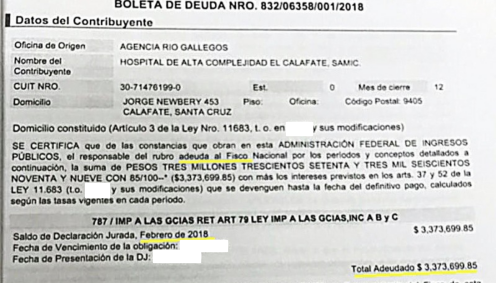

In [39]:
Image.open(buffer)